In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.feature
import skimage.segmentation
import skimage.filters
import skimage.transform
import scipy
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing
import itertools as it

from ipywidgets import interact
from IPython.display import display
from pydash import py_

from cad.metrics import geometry, exposure

plt.rcParams['figure.figsize'] = [10.0, 8.0]

In [3]:
class Grid(object):
  R_SIGMA = (50, 0)
  R_MORPH = (80, 2)
  
  def __init__(self, fname):
    self._img = skimage.io.imread(fname)
    self.img = exposure.equalize(self._img)

  def _scan_filtered(self, img, axis=0):
    _d = 1 if axis else -1
    _a = 0 if axis else 1
    igauss = skimage.filters.gaussian(img, sigma=self.R_SIGMA[::_d], mode='reflect')
    ieroded = skimage.morphology.erosion(igauss, skimage.morphology.rectangle(*self.R_MORPH[::_d]))
    return ieroded.mean(axis=_a)
  
  def _scan_quick(self, img, axis=0):
    _a = 0 if axis else 1
    return img.mean(axis=_a)
  
  def _scan_profile(self, theta=0, quick=True):
    img = skimage.transform.rotate(self.img, theta, cval=1)
    routine = self._scan_quick if quick else self._scan_filtered
    return [routine(img=img, axis=x) for x in [0, 1]]    
  
  def _scan_immediate(self, theta=0):
    img = skimage.transform.rotate(self.img, theta, cval=1)
    return [scipy.stats.entropy(x) for x in [img, img.transpose()]]

In [7]:
go = Grid('/d/blimp/c1.jpg')
profile = []
thetas = np.arange(-3, 3, 0.1)
for i in thetas:
  profile.append(go._scan_immediate(i))

spanx = [(x.max() - x.min()) for x, _ in profile]
spany = [(x.max() - x.min()) for _, x in profile]

/Users/prashantsinha/.virtualenvs/blimp/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


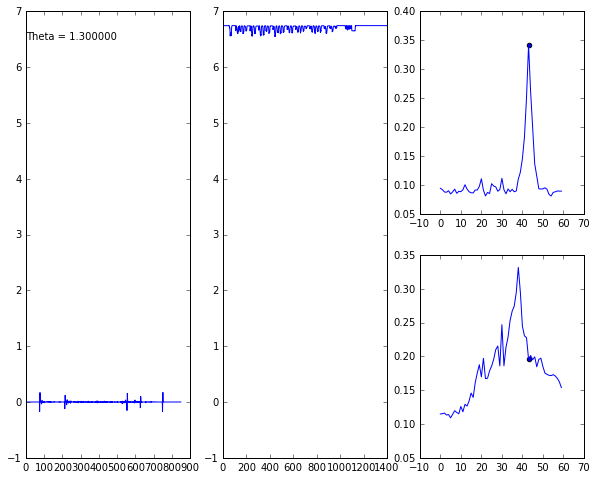

In [9]:
@interact(i=(0, len(profile) - 1))
def pl(i):
  h, v = profile[i]
  l = plt.subplot2grid([2, 3], [0, 0], rowspan=2)
  plt.plot(np.gradient(h))
  plt.text(0, 6.5, 'Theta = %f' % thetas[i])
  plt.subplot2grid([2, 3], [0, 1], rowspan=2, sharey=l)
  plt.plot(v)
#   plt.ylim(6, 8)
  plt.subplot2grid([2, 3], [0, 2])
  plt.plot(spanx)
  plt.scatter([i], [h.max() - h.min()])
  plt.subplot2grid([2, 3], [1, 2])
  plt.plot(spany)
  plt.scatter([i], [v.max() - v.min()])